In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import train_test_split,GridSearchCV
import pyarrow
import sys
import os

from sklearn.svm import SVC

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
# from Utils.constants import DATASETS_FOLDER_PATH
from Utils.constants import CLASSIFIERS_COLUMN
from sklearn.ensemble import RandomForestClassifier
from Utils.data_utils import *
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [269]:
df = load_data_from_folder()
df = df.drop(columns=['file_name'])
print('shape =',df.shape)

df.describe()

shape = (3276, 10)


ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [271]:
min_max_dict = {}
    
for column in df.columns:
    min_value = df[column].min()
    max_value = df[column].max()
    min_max_dict[column] = {'min': min_value,'max':  max_value}
min_max_dict

{'ph': {'min': 0.0, 'max': 13.999999999999998},
 'Hardness': {'min': 47.432, 'max': 323.124},
 'Solids': {'min': 320.942611274359, 'max': 61227.19600771213},
 'Chloramines': {'min': 0.3520000000000003, 'max': 13.127000000000002},
 'Sulfate': {'min': 129.00000000000003, 'max': 481.0306423059972},
 'Conductivity': {'min': 181.483753985146, 'max': 753.3426195583046},
 'Organic_carbon': {'min': 2.1999999999999886, 'max': 28.30000000000001},
 'Trihalomethanes': {'min': 0.7379999999999995, 'max': 124.0},
 'Turbidity': {'min': 1.45, 'max': 6.739},
 'Potability': {'min': 0, 'max': 1}}

In [272]:
def calculate_mean_std_normalize(dataframe, standards=None):
    """
    Calculate mean, standard deviation, and normalize with Z-score for each column in a DataFrame.
    
    Parameters:
    dataframe (pandas.DataFrame): Input DataFrame.
    standards (dict): Dictionary containing standard values for normalization. If None, no normalization will be done.
    
    Returns:
    dict: A dictionary where keys are column names and values are tuples containing mean, standard deviation,
          and normalized values (if standards are provided).
    """
    result_dict = {}
    
    for column in dataframe.columns:
        mean_value = dataframe[column].mean()
        std_value = dataframe[column].std()
        min = dataframe[column].min()
        max = dataframe[column].max()
        if standards is not None and column in standards:
            result_dict[column] = (standards[column] - min_max_dict[column]['min']) /( min_max_dict[column]['max'] - min_max_dict[column]['min'] )
    return result_dict

standards = {
    'ph': 7,
    'Hardness': 85,
    'Solids': 500,
    'Chloramines': 4,
    'Sulfate': 250,
    'Conductivity': 600,
    'Organic_carbon': 8,
    'Trihalomethanes': 13,
    'Turbidity': 2
}
df_subset = df.drop('Potability',axis=1)
standards = calculate_mean_std_normalize(df_subset,standards)
standards

{'ph': 0.5000000000000001,
 'Hardness': 0.13626800922768886,
 'Solids': 0.002939885130680416,
 'Chloramines': 0.2855577299412915,
 'Sulfate': 0.3437200784777781,
 'Conductivity': 0.7318523349207615,
 'Organic_carbon': 0.22222222222222246,
 'Trihalomethanes': 0.09947915821583295,
 'Turbidity': 0.10398941198714313}

In [273]:
weights = {
    'ph': 0.1,
    'Hardness': 0.1,
    'Solids': 0.1,
    'Chloramines': 0.1,
    'Sulfate': 0.1,
    'Conductivity': 0.1,
    'Organic_carbon': 0.1,
    'Trihalomethanes': 0.1,
    'Turbidity': 0.1
}
standards = {
    'ph': 7,
    'Hardness': 85,
    'Solids': 500,
    'Chloramines': 4,
    'Sulfate': 250,
    'Conductivity': 600,
    'Organic_carbon': 8,
    'Trihalomethanes': 13,
    'Turbidity': 2
}

In [274]:
def calculate_wqi(df, parameters, standards, weights):
    # Check if DataFrame contains all parameters
    missing_params = [param for param in parameters if param not in df.columns]
    if missing_params:
        raise ValueError(f"DataFrame is missing parameters: {', '.join(missing_params)}")

    # Calculate sub-indices for each parameter
    sub_indices = {param: df[param] / standards[param] for param in parameters}

    # Calculate WQI for each row
    wqi_values = []
    for index, row in df.iterrows():
        weighted_sum = sum(sub_indices[param][index] * weights[param] for param in parameters)
        wqi_values.append(weighted_sum)

    # Add WQI column to DataFrame
    df['WQI'] = wqi_values

    return df

In [275]:
df_with_wqi = calculate_wqi(df, parameters=['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity'], standards=standards, weights=weights)
df_with_wqi

ph    Hardness        Solids  Chloramines     Sulfate  \
0          NaN  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246         NaN   
2     8.099124  224.236259  19909.541732     9.275884         NaN   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362         NaN   
3273  9.419510  175.762646  33155.578218     7.350233         NaN   
3274  5.126763  230.603758  11983.869376     6.303357         NaN   
3275  7.874671  195.102299  17404.177061     7.509306         NaN   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  \
0       564.308654       10.379783        86.990970   2.963135           0   
1       592.885359       15.180013        56.329076   4.500656           0   
2       418.606213       16.868637        66.420093   3.055934           0   
3       363.266516       18.436524       100.341674   4.628771           0   
4       398.410813       11.558279        31.997993   4.075075           0   
...            ...             ...              ...        ...         ...   
3271    526.424171       13.894419        66.687695   4.435821           1   
3272    392.449580       19.903225              NaN   2.798243           1   
3273    432.044783       11.039070        69.845400   3.298875           1   
3274    402.883113       11.168946        77.488213   4.708658           1   
3275    327.459760       16.140368        78.698446   2.309149           1   

            WQI  
0           NaN  
1           NaN  
2           NaN  
3      6.413235  
4      4.887239  
...         ...  
3271  11.130083  
3272        NaN  
3273        NaN  
3274        NaN  
3275        NaN  

[3276 rows x 11 columns]

In [277]:
df_with_wqi['WQI'].max()

12.78088722776045

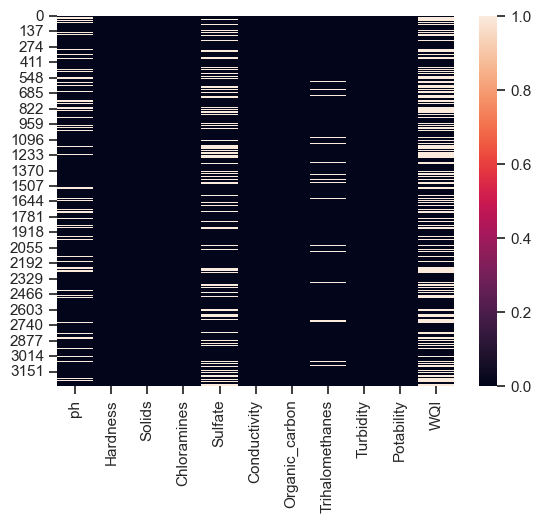

In [278]:
sns.heatmap(df_with_wqi.isnull());

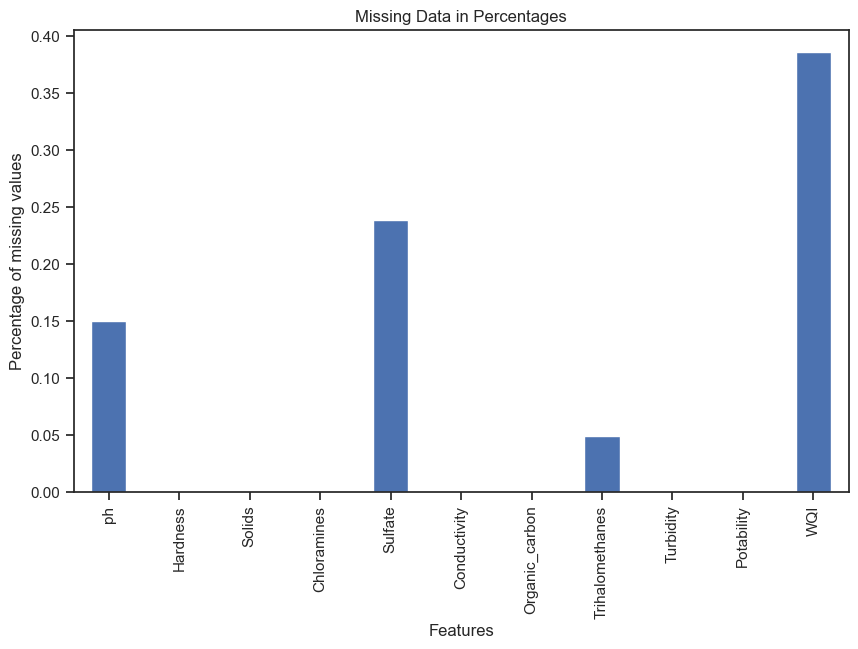

In [279]:
df_with_wqi.isnull().mean().plot.bar(figsize=(10,6)) 
plt.ylabel('Percentage of missing values') 
plt.xlabel('Features') 
plt.title('Missing Data in Percentages');

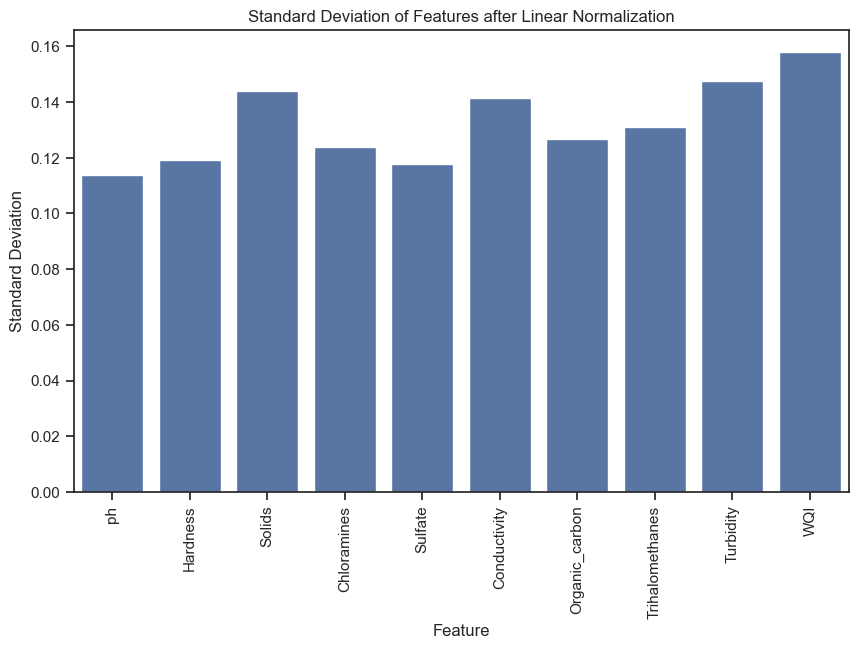

In [280]:
# Assuming df is your DataFrame containing the data
df_features = df_with_wqi.drop(['Potability'], axis=1,inplace=False)
normalized_mX = (df_features - df_features.min()) / (df_features.max() - df_features.min())  # Linearly normalize each feature to have a max of 1
std = normalized_mX.std()  # Calculate the standard deviation of each feature

# Plot the standard deviation of each feature after linear normalization
plt.figure(figsize=(10, 6))
sns.barplot(x=std.index, y=std.values)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Features after Linear Normalization')
plt.show()

(3276, 11)


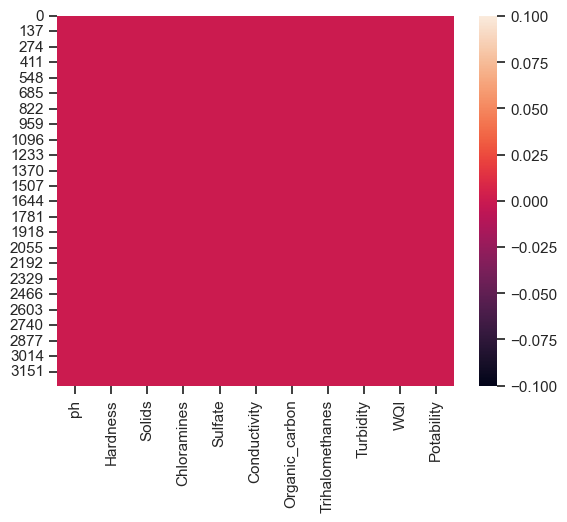

In [281]:
# clean data - after cleaning
df_clean = normalized_mX.copy()
df_clean = pd.concat([df_clean, df['Potability']], axis=1) # add back potability column

# remove null rows
# df_clean.dropna(inplace=True)

# mean null rows
# df_clean.fillna(normalized_df.mean(), inplace=True)

# KNN Imputer
imputer = KNNImputer(n_neighbors=5) # Create a KNN imputer
df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

# Iterative Imputer
# imputer = IterativeImputer(random_state=0, skip_complete=True)  # Create an IterativeImputer
# df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)


print(df_clean.shape)

sns.heatmap(df_clean.isnull());

In [282]:
vY = df_clean[CLASSIFIERS_COLUMN]
mX = df_clean.drop(CLASSIFIERS_COLUMN,axis=1)

In [284]:
mX['WQI'].min()

0.0

In [255]:
def normalize_df(df):
    # Calculate Z-scores for each column
    z_scores = (df - df.mean()) / df.std()
    
    return z_scores

In [256]:
def visualize_outliers(normalized_df, threshold=3):
    # Identify outliers
    outliers = (np.abs(normalized_df) > threshold)
    
    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=len(normalized_df.columns), figsize=(15, 5))
    fig.suptitle('Visualizing Outliers')

    for i, col in enumerate(normalized_df.columns):
        ax = axes[i] if len(normalized_df.columns) > 1 else axes
        ax.scatter(range(len(normalized_df)), normalized_df[col], label=col)
        ax.scatter(outliers.index[outliers[col]], normalized_df[col][outliers[col]], color='red', label='Outliers')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.set_title(col)
        ax.legend()

    plt.tight_layout()
    plt.show()

In [257]:
# normalized_mX = normalize_df(mX)
# visualize_outliers(normalized_mX, threshold=3)

In [258]:
def count_rows_with_outliers(df, threshold=3):
    outliers_mask = (np.abs(df) > threshold).any(axis=1)
    num_rows_with_outliers = outliers_mask.sum()
    return num_rows_with_outliers

def count_outliers_per_column(df, threshold=3):
    outliers_per_column = (np.abs(df) > threshold).sum()
    return outliers_per_column

In [259]:
# count_rows_with_outliers(normalized_mX, threshold=3)

In [260]:
# count_outliers_per_column(normalized_mX)

In [261]:
def remove_outliers(df, threshold=3):
    z_scores = (df - df.mean()) / df.std()
    outliers_mask = (np.abs(z_scores) > threshold).any(axis=1)
    df_cleaned = df[~outliers_mask]
    return df_cleaned

In [262]:
# normalized_df = pd.concat([normalized_mX, vY], axis=1)
# df_without_outliers = remove_outliers(normalized_df, threshold=3)

In [285]:
def balance_df_with_smote(df, target_column):
    # Separate features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Apply SMOTE to balance the dataset
    smote = SMOTE(sampling_strategy='auto', random_state=42 , k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    # Combine balanced features and target variable into a DataFrame
    balanced_df = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(y_balanced, name=target_column)], axis=1)
    
    return balanced_df

In [264]:
# df_without_outliers

In [265]:
df_balanced = balance_df_with_smote(df_clean,'Potability')

<module 'matplotlib.pyplot' from 'C:\\Users\\yuval.yarom\\AppData\\Local\\mambaforge\\envs\\Predicting-Drinking-Water-Potability\\Lib\\site-packages\\matplotlib\\pyplot.py'>

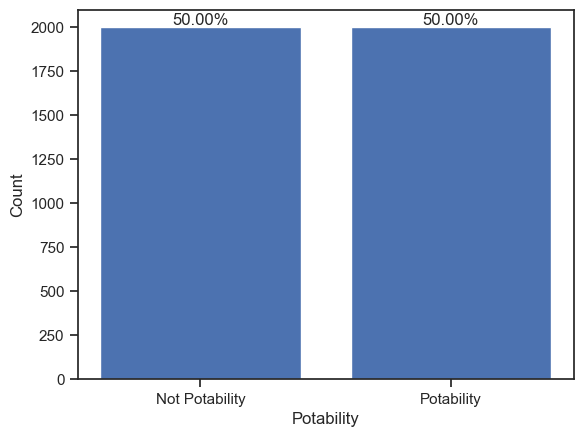

In [266]:
from Utils.DataVisualization import * 
get_balance_plot(df_balanced,'Potability')

In [223]:
def calculate_wqi(df, parameters, standards, weights):
    # Check if DataFrame contains all parameters
    missing_params = [param for param in parameters if param not in df.columns]
    if missing_params:
        raise ValueError(f"DataFrame is missing parameters: {', '.join(missing_params)}")

    # Calculate sub-indices for each parameter
    sub_indices = {param: df[param] / standards[param] for param in parameters}

    # Calculate WQI for each row
    wqi_values = []
    for index, row in df.iterrows():
        weighted_sum = sum(sub_indices[param][index] * weights[param] for param in parameters)
        wqi_values.append(weighted_sum)

    # Add WQI column to DataFrame
    df['WQI'] = wqi_values

    return df

In [224]:

# weights = {
#     'ph': 0.229240,
#     'Hardness': 0.113918,
#     'Solids': 0.135622,
#     'Chloramines': 0.113747,
#     'Sulfate': 0.218921,
#     'Conductivity': 0.046059,
#     'Organic_carbon': 0.060725,
#     'Trihalomethanes': 0.048147,
#     'Turbidity': 0.033621
# }

weights = {
    'ph': 0.1,
    'Hardness': 0.1,
    'Solids': 0.1,
    'Chloramines': 0.1,
    'Sulfate': 0.1,
    'Conductivity': 0.1,
    'Organic_carbon': 0.1,
    'Trihalomethanes': 0.1,
    'Turbidity': 0.1
}

In [235]:
standards

{'ph': 0.5000000000000001,
 'Hardness': 0.13626800922768886,
 'Solids': 0.002939885130680416,
 'Chloramines': 0.2855577299412915,
 'Sulfate': 0.3437200784777781,
 'Conductivity': 0.7318523349207615,
 'Organic_carbon': 0.22222222222222246,
 'Trihalomethanes': 0.09947915821583295,
 'Turbidity': 0.10398941198714313}

In [225]:
# df_with_wqi = calculate_wqi(df_balanced, parameters=['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity'], standards=standards, weights=weights)
# df_with_wqi

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0     0.502784  0.571139  0.336096     0.543891  0.680385      0.669439   
1     0.265434  0.297400  0.300611     0.491839  0.602571      0.719411   
2     0.578509  0.641311  0.321619     0.698543  0.563298      0.414652   
3     0.594055  0.605536  0.356244     0.603314  0.647347      0.317880   
4     0.649445  0.484851  0.289922     0.484900  0.514545      0.379337   
...        ...       ...       ...          ...       ...           ...   
3991  0.560356  0.434710  0.215044     0.535173  0.515598      0.341800   
3992  0.369342  0.453484  0.419993     0.555453  0.659636      0.310077   
3993  0.514873  0.394047  0.550464     0.706030  0.415335      0.544953   
3994  0.500670  0.484272  0.490260     0.783886  0.364165      0.535721   
3995  0.514342  0.591998  0.291458     0.547366  0.687647      0.562411   

      Organic_carbon  Trihalomethanes  Turbidity  Potability        WQI  
0           0.313402         0.699753   0.286091         0.0  13.551434  
1           0.497319         0.450999   0.576793         0.0  12.174277  
2           0.562017         0.532866   0.303637         0.0  13.071886  
3           0.622089         0.808065   0.601015         0.0  14.794032  
4           0.358555         0.253606   0.496327         0.0  11.612272  
...              ...              ...        ...         ...        ...  
3991        0.578386         0.497830   0.644700         1.0   9.510573  
3992        0.418230         0.518917   0.459890         1.0  16.273562  
3993        0.446907         0.582838   0.610959         1.0  20.933188  
3994        0.349975         0.552053   0.439660         1.0  18.720548  
3995        0.443509         0.715285   0.641986         1.0  12.455784  

[3996 rows x 11 columns]

In [226]:
df_balanced

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0     0.502784  0.571139  0.336096     0.543891  0.680385      0.669439   
1     0.265434  0.297400  0.300611     0.491839  0.602571      0.719411   
2     0.578509  0.641311  0.321619     0.698543  0.563298      0.414652   
3     0.594055  0.605536  0.356244     0.603314  0.647347      0.317880   
4     0.649445  0.484851  0.289922     0.484900  0.514545      0.379337   
...        ...       ...       ...          ...       ...           ...   
3991  0.560356  0.434710  0.215044     0.535173  0.515598      0.341800   
3992  0.369342  0.453484  0.419993     0.555453  0.659636      0.310077   
3993  0.514873  0.394047  0.550464     0.706030  0.415335      0.544953   
3994  0.500670  0.484272  0.490260     0.783886  0.364165      0.535721   
3995  0.514342  0.591998  0.291458     0.547366  0.687647      0.562411   

      Organic_carbon  Trihalomethanes  Turbidity  Potability        WQI  
0           0.313402         0.699753   0.286091         0.0  13.551434  
1           0.497319         0.450999   0.576793         0.0  12.174277  
2           0.562017         0.532866   0.303637         0.0  13.071886  
3           0.622089         0.808065   0.601015         0.0  14.794032  
4           0.358555         0.253606   0.496327         0.0  11.612272  
...              ...              ...        ...         ...        ...  
3991        0.578386         0.497830   0.644700         1.0   9.510573  
3992        0.418230         0.518917   0.459890         1.0  16.273562  
3993        0.446907         0.582838   0.610959         1.0  20.933188  
3994        0.349975         0.552053   0.439660         1.0  18.720548  
3995        0.443509         0.715285   0.641986         1.0  12.455784  

[3996 rows x 11 columns]

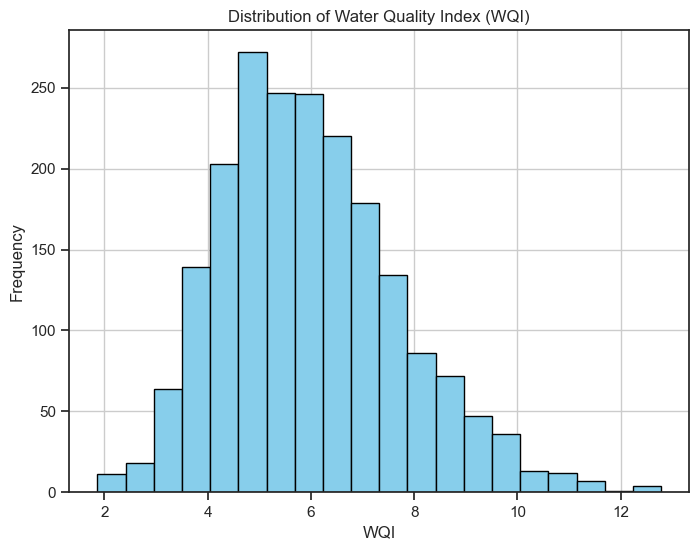

In [267]:
def plot_wqi_distribution(df):
    # Plot histogram of WQI values
    plt.figure(figsize=(8, 6))
    plt.hist(df['WQI'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Water Quality Index (WQI)')
    plt.xlabel('WQI')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage
# Assuming 'df_with_wqi' is your DataFrame containing the WQI column
plot_wqi_distribution(df_with_wqi)

In [228]:
type(df_with_wqi)

pandas.core.frame.DataFrame

In [229]:
df_with_wqi.shape

(3996, 11)

In [230]:
df_with_wqi

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0     0.502784  0.571139  0.336096     0.543891  0.680385      0.669439   
1     0.265434  0.297400  0.300611     0.491839  0.602571      0.719411   
2     0.578509  0.641311  0.321619     0.698543  0.563298      0.414652   
3     0.594055  0.605536  0.356244     0.603314  0.647347      0.317880   
4     0.649445  0.484851  0.289922     0.484900  0.514545      0.379337   
...        ...       ...       ...          ...       ...           ...   
3991  0.560356  0.434710  0.215044     0.535173  0.515598      0.341800   
3992  0.369342  0.453484  0.419993     0.555453  0.659636      0.310077   
3993  0.514873  0.394047  0.550464     0.706030  0.415335      0.544953   
3994  0.500670  0.484272  0.490260     0.783886  0.364165      0.535721   
3995  0.514342  0.591998  0.291458     0.547366  0.687647      0.562411   

      Organic_carbon  Trihalomethanes  Turbidity  Potability        WQI  
0           0.313402         0.699753   0.286091         0.0  13.551434  
1           0.497319         0.450999   0.576793         0.0  12.174277  
2           0.562017         0.532866   0.303637         0.0  13.071886  
3           0.622089         0.808065   0.601015         0.0  14.794032  
4           0.358555         0.253606   0.496327         0.0  11.612272  
...              ...              ...        ...         ...        ...  
3991        0.578386         0.497830   0.644700         1.0   9.510573  
3992        0.418230         0.518917   0.459890         1.0  16.273562  
3993        0.446907         0.582838   0.610959         1.0  20.933188  
3994        0.349975         0.552053   0.439660         1.0  18.720548  
3995        0.443509         0.715285   0.641986         1.0  12.455784  

[3996 rows x 11 columns]

In [231]:
df_with_wqi.shape

(3996, 11)

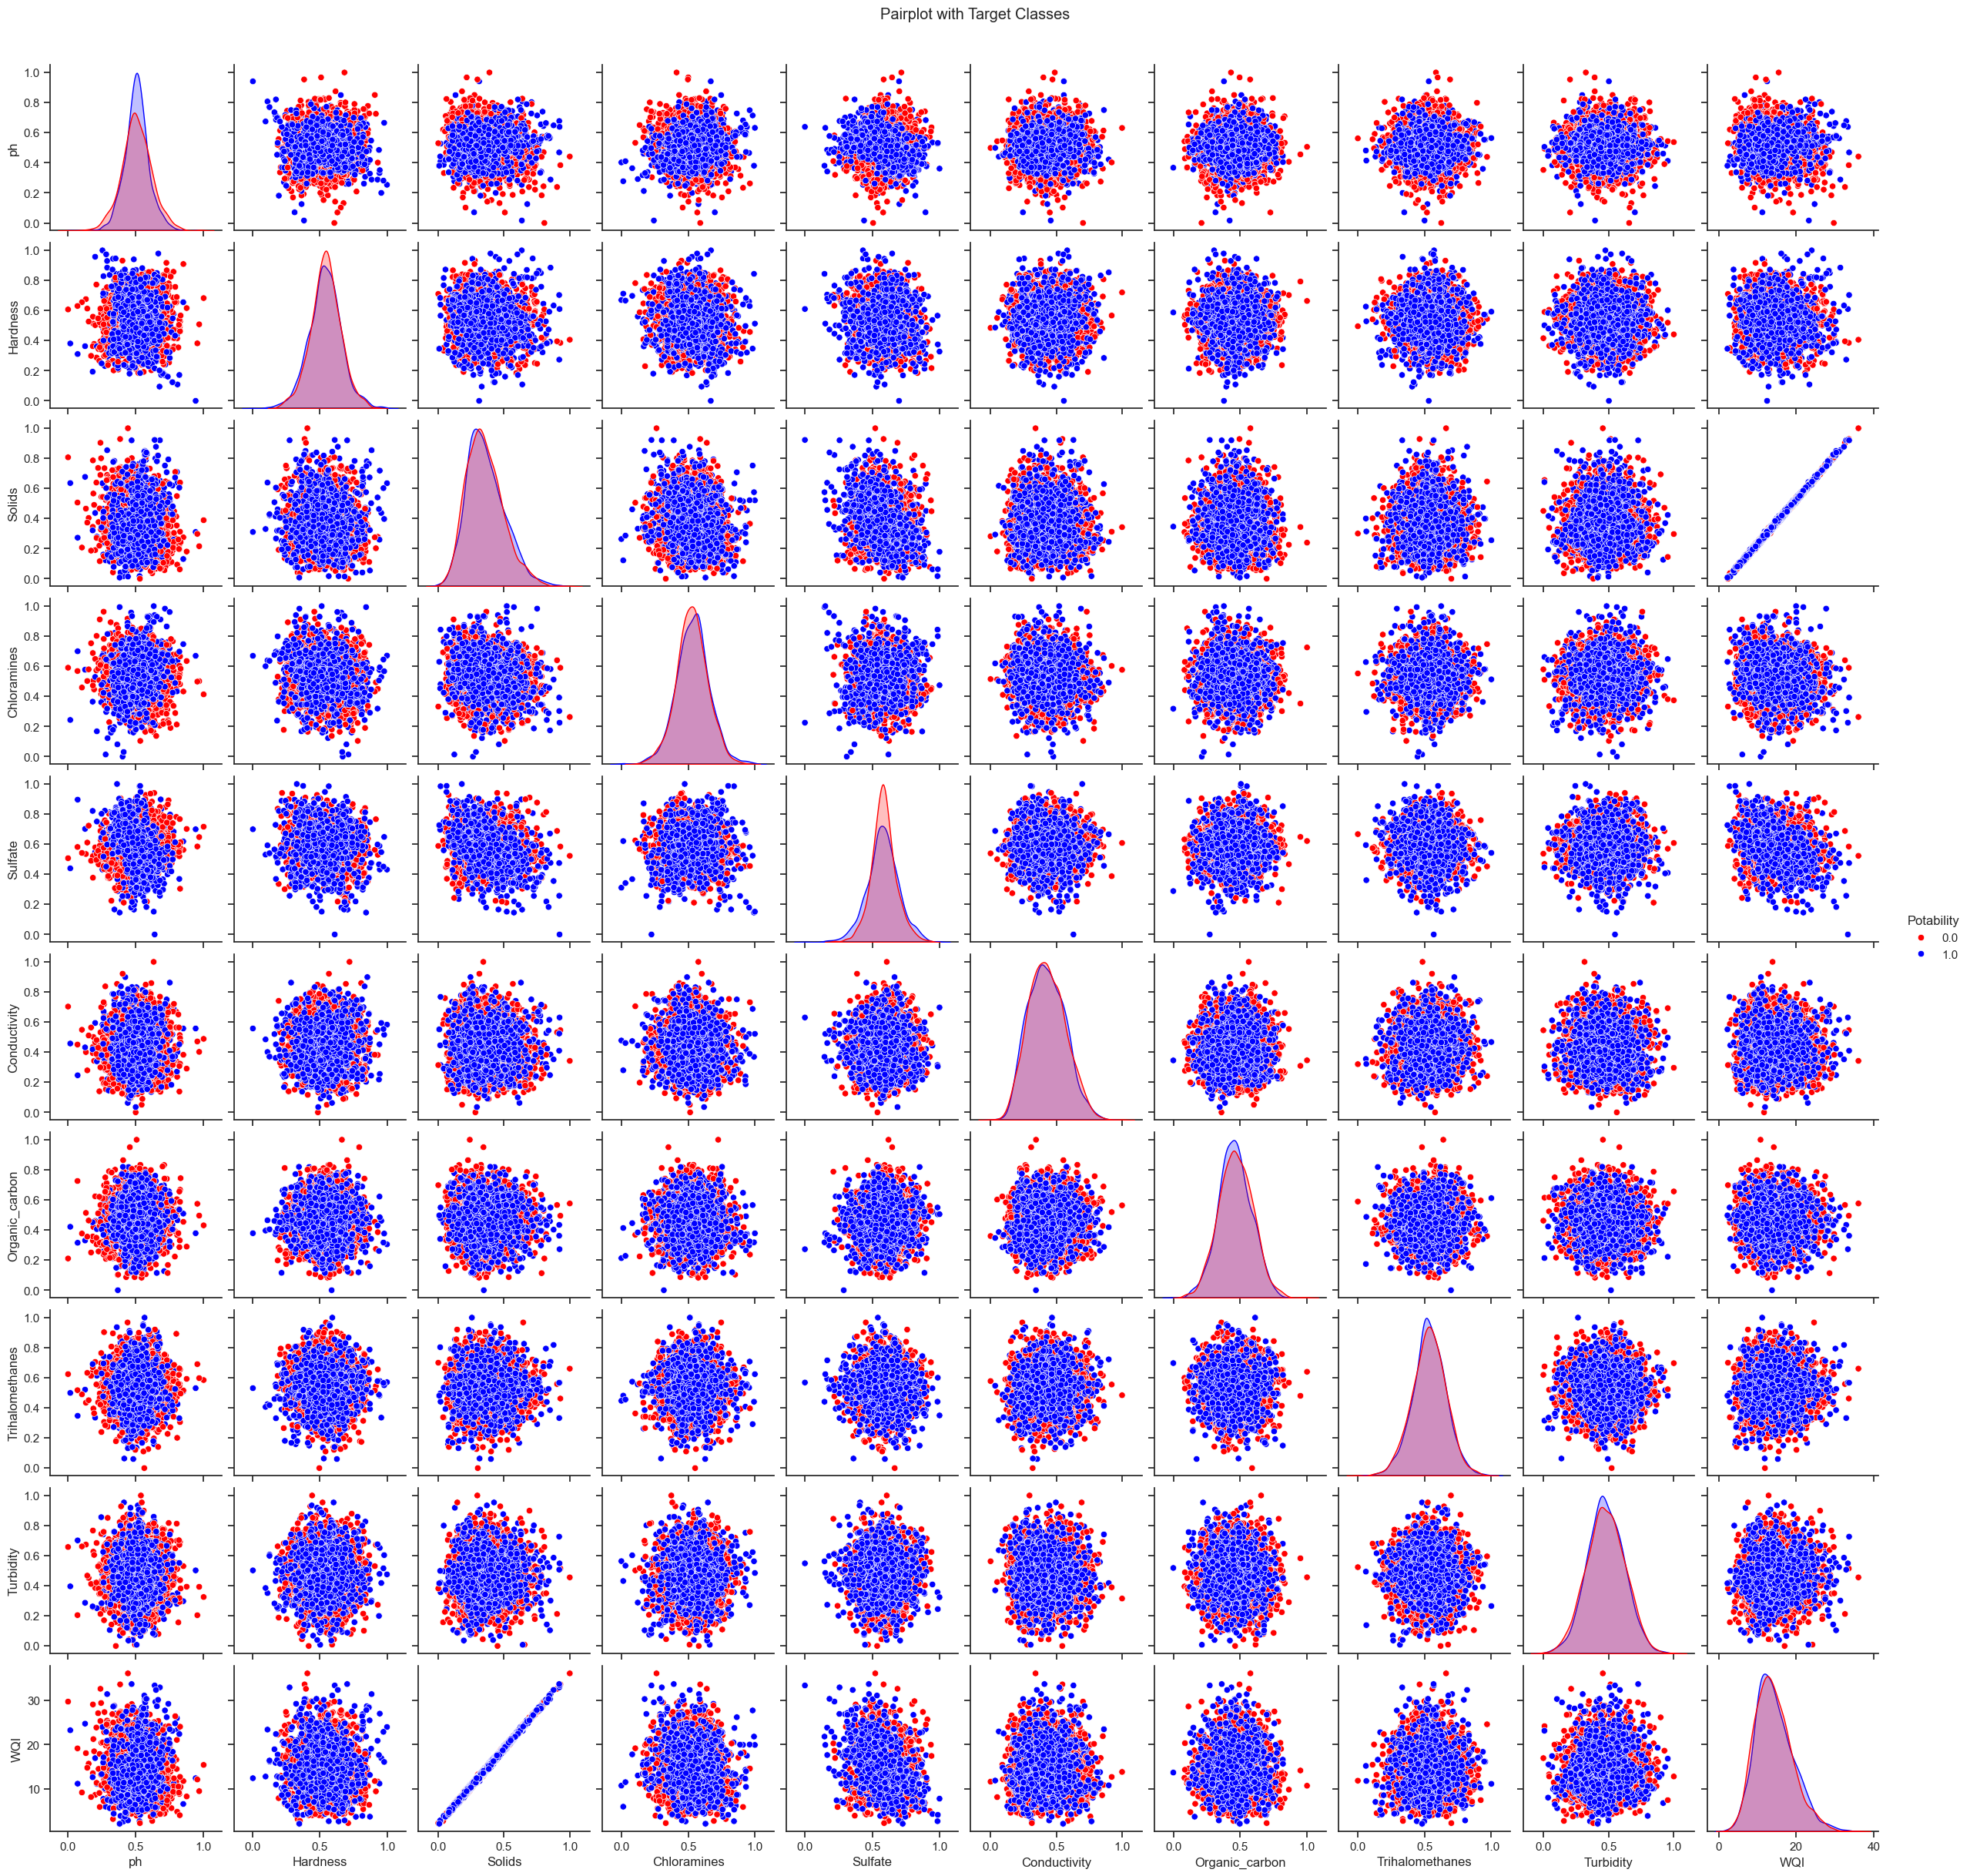

In [232]:
pairplot = get_pairplot(df_with_wqi,CLASSIFIERS_COLUMN)
pairplot

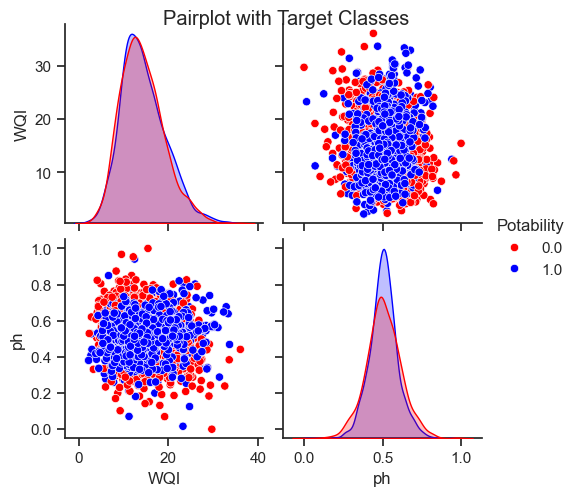

In [233]:
pairplot = get_pairplot(df_with_wqi[['WQI','ph','Potability']],CLASSIFIERS_COLUMN)
pairplot

<Axes: >

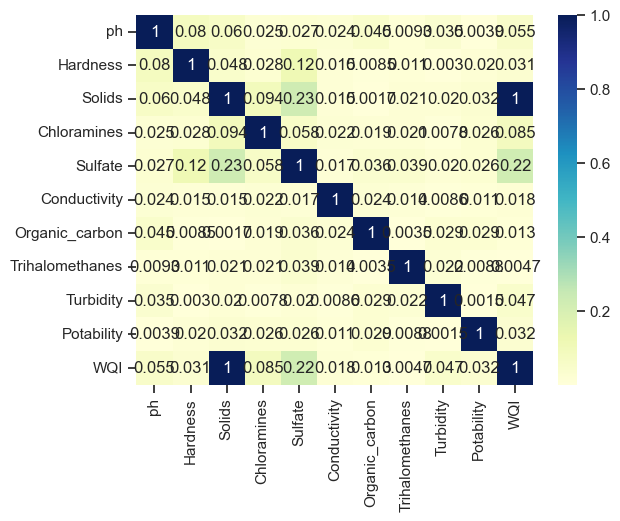

In [234]:
get_corraletion_metrix(df_with_wqi)

<module 'matplotlib.pyplot' from 'C:\\Users\\yuval.yarom\\AppData\\Local\\mambaforge\\envs\\Predicting-Drinking-Water-Potability\\Lib\\site-packages\\matplotlib\\pyplot.py'>

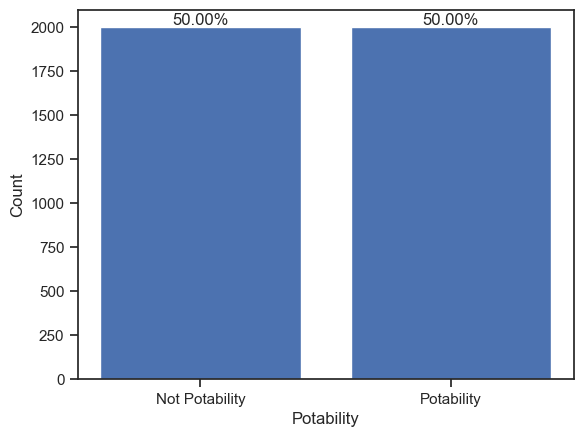

In [183]:
get_balance_plot(df_with_wqi,'Potability')

In [184]:
df_train , df_test = train_test_split(df_with_wqi,train_size=0.3,test_size=0.7, shuffle = True, stratify = df_with_wqi['Potability'])

In [185]:
df_test

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
1046  0.480964  0.544559  0.445102     0.444860  0.496939      0.378067   
2661  0.558547  0.644469  0.264062     0.527696  0.523159      0.405214   
2096  0.826341  0.527735  0.638909     0.666048  0.303938      0.493044   
1042  0.392821  0.663337  0.222999     0.725446  0.633707      0.455852   
1999  0.553555  0.660367  0.355860     0.579015  0.543818      0.379571   
...        ...       ...       ...          ...       ...           ...   
2452  0.469218  0.585071  0.472903     0.502005  0.564433      0.221387   
1673  0.562607  0.738014  0.253178     0.604598  0.605482      0.366830   
2988  0.414398  0.560265  0.246394     0.509483  0.567941      0.174171   
1621  0.576378  0.520770  0.268176     0.601660  0.629428      0.413942   
3368  0.769942  0.123844  0.428571     0.636140  0.539834      0.370374   

      Organic_carbon  Trihalomethanes  Turbidity  Potability       WQI  
1046        0.658775         0.436247   0.326717         0.0 -0.631210  
2661        0.504813         0.259154   0.180060         0.0 -0.681531  
2096        0.667746         0.655178   0.436999         0.0 -0.903339  
1042        0.480490         0.521542   0.831315         0.0 -1.069118  
1999        0.613139         0.327159   0.542104         1.0 -0.794380  
...              ...              ...        ...         ...       ...  
2452        0.389283         0.527431   0.520836         1.0 -0.725685  
1673        0.549574         0.474664   0.465855         0.0 -0.841590  
2988        0.674808         0.443442   0.562560         0.0 -0.750813  
1621        0.386734         0.391615   0.297104         1.0 -0.800969  
3368        0.404902         0.418109   0.599072         1.0 -0.835023  

[2798 rows x 11 columns]

<module 'matplotlib.pyplot' from 'C:\\Users\\yuval.yarom\\AppData\\Local\\mambaforge\\envs\\Predicting-Drinking-Water-Potability\\Lib\\site-packages\\matplotlib\\pyplot.py'>

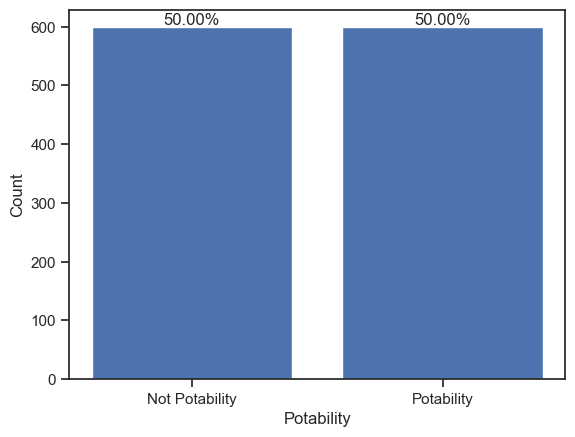

In [186]:
get_balance_plot(df_train,'Potability')

In [187]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, precision_recall_fscore_support


def svm_model(train_df, test_df):
    # Extracting features and target variable from train and test DataFrames
    X_train = train_df.drop(columns=[CLASSIFIERS_COLUMN])
    y_train = train_df[CLASSIFIERS_COLUMN]
    X_test = test_df.drop(columns=[CLASSIFIERS_COLUMN])
    y_test = test_df[CLASSIFIERS_COLUMN]
    
    # Initializing and fitting logistic regression model
    vC = [0.001, 0.01, 0.1, 1, 10]
    vGamma = ['scale','auto']
    param_grid = [
        {'kernel':['poly'], 'C':vC,'degree':[2, 3],'gamma':vGamma},
        {'kernel':['rbf'], 'C':vC, 'gamma':vGamma,},
        {'kernel':['sigmoid'], 'C':vC, 'gamma':vGamma,},
    ]
    
    # Initialize SVC model
    svc = SVC()
    
    # Perform grid search cross-validation to find best hyperparameters
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1', n_jobs=-1,refit=True)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    # Get the best hyperparameters
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    # Compute average scores
    
    
    return best_model, f1, precision, recall

In [188]:
trained_model, f1, precision, recall = svm_model(df_train, df_test)
print("F1 Test Score:", f1)
print("Precision Test Score:", precision)
print("Recall Test Score:", recall)


F1 Test Score: 0.571078431372549
Precision Test Score: 0.6663489037178265
Recall Test Score: 0.4996426018584703


In [189]:
trained_model.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}